In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
# read in the data and parse date
analytics = pd.read_csv('challenge_analytics.csv', index_col=0, infer_datetime_format=True,
                        parse_dates=['TIMESTAMP'], date_parser=lambda x: pd.to_datetime(x).tz_convert('UTC').tz_localize(None).round('h'))

In [3]:
# drop duplicate column
analytics.drop('obsf_user_id', axis=1, inplace=True)
# lowercase column names
analytics.columns = analytics.columns.str.lower()
# format session_id
analytics['session_id'] = analytics['session_id'].map(lambda x: '{:.0f}'.format(x))
analytics.head()

,timestamp,session_id,event_type,platform,event_source,keyword,obj_id,obsf_user_id,obsf_store_type
0,2019-04-16 17:00:00,1555435344599,view_store_type,Android,MARKET,NaN,NaN,0,0
1,2019-04-16 04:00:00,1555362362367,view_product_description,Android,LOCAL_SEARCH,NaN,5cb4f279ee88fc0015b411d6,1,1
2,2019-04-17 04:00:00,1555447661171,local_search,iOS,TYPED,zop,NaN,2,2
3,2019-04-16 08:00:00,1555376724641,add_to_cart,iOS,VIEW_PRODUCT_DESCRIPTION,NaN,NaN,3,3
4,2019-04-16 05:00:00,1555366969513,local_search,iOS,TYPED,lentejas,NaN,4,1


In [4]:
# read in the data parse date
orders = pd.read_csv('challenge_orders.csv',  index_col=0, infer_datetime_format=True,
                        parse_dates=['CREATED_AT'], date_parser=lambda x: pd.to_datetime(x).tz_convert('UTC').tz_localize(None).round('h'))

In [5]:
# lowercase column names
orders.columns = orders.columns.str.lower()
orders.head()

,order_id,product_id,payment_method,total_value,created_at,store_to_user_distance,obsf_user_id,obsf_store_type
0,35394843,2090144731,cash,1940.0,2019-04-15 14:00:00,488.0,8540,5
1,35419116,2090144731,cc,8900.0,2019-04-16 21:00:00,4761.0,3990,14
2,35404241,2090144731,cash,150.0,2019-04-15 21:00:00,3141.0,19052,5
3,35405366,2090144731,cash,400.0,2019-04-15 22:00:00,3070.0,16978,14
4,35406544,2090144731,cash,9580.0,2019-04-16 00:00:00,1210.0,9521,5


# Exploratory Data Analysis

In [6]:
# create functions to easily plot figures
def barplot(index, column, title, xlabel, ylabel, size):
    pd.crosstab(index,column).plot(kind='bar', stacked=True, rot=0, alpha=0.5, align='center', width=0.7, figsize=size)
    # remove all the ticks (both axes)
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    # remove the frame of the chart
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plotting(df, column, agg_by, head, title, xlabel):
    df.groupby(column).agg({agg_by:'count'}).sort_values(agg_by, ascending=False).head(head).plot(kind='bar', sort_columns=True, figsize=(10,5), title=title)
    plt.xlabel(xlabel)
    plt.ylabel('# of queries')
    plt.show()

## Orders

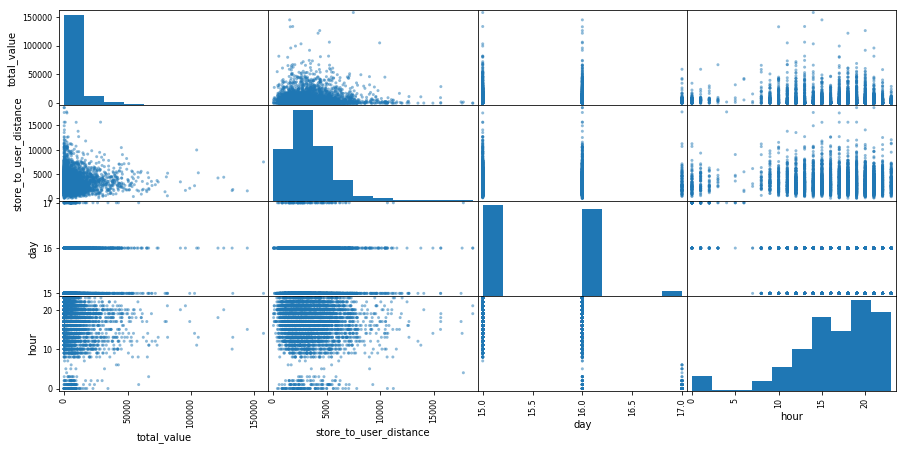

In [26]:
pd.plotting.scatter_matrix(df[['total_value','store_to_user_distance','day', 'hour']], figsize=(15,7))
plt.show()

- Payment method seems pretty balanced.

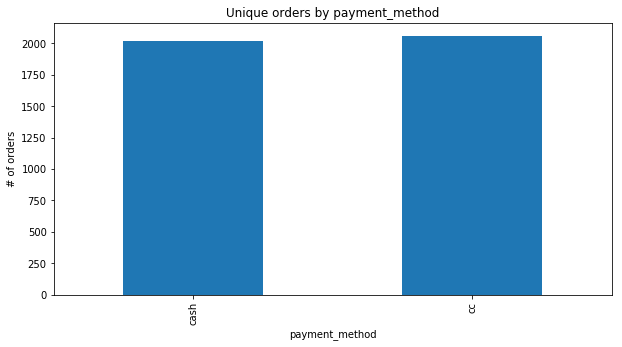

In [7]:
orders.groupby('payment_method')['obsf_user_id'].nunique().plot(kind='bar', sort_columns=True, figsize=(10,5), title='Unique orders by payment_method')
plt.xlabel('payment_method')
plt.ylabel('# of orders')
plt.show()

- Top 20 sold products

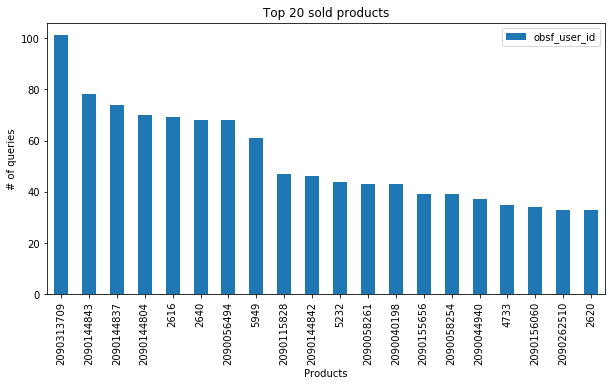

In [8]:
plotting(orders,'product_id','obsf_user_id', 20, 'Top 20 sold products', 'Products')

- Is there a difference between the payment method by total amount? Yes! People tend to pay more often with credit card when the total amount is higher than 5k. Let's look at the graphics below.

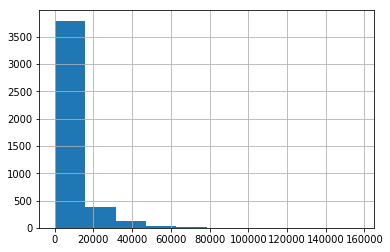

In [9]:
# total_value distribution
df = orders.drop_duplicates(subset='order_id').copy()
df['total_value'].hist()

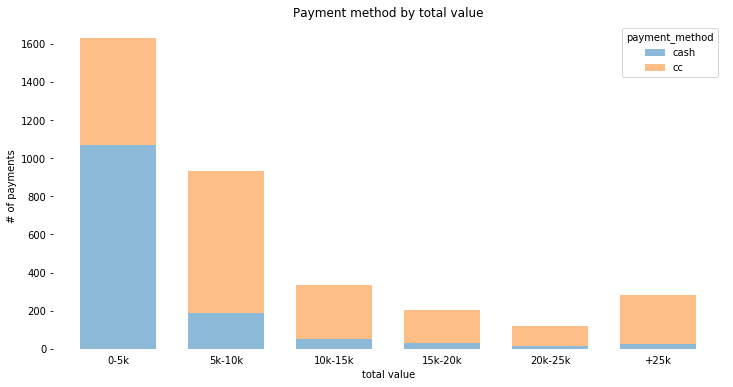

In [10]:
df_expl = df.copy()
# segment and sort data values into bins
df_expl['total_value_cat'] = pd.cut(df['total_value'], bins=[0, 5000, 10000, 15000, 20000, 25000, np.inf], 
                               labels=['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '+25k'])
barplot(df_expl['total_value_cat'], df['payment_method'], 'Payment method by total value','total value', '# of payments', (12,6))

- Does the payment method differs by store type? There is a difference in some stores. people prefer to use a payment method depending on the store.  

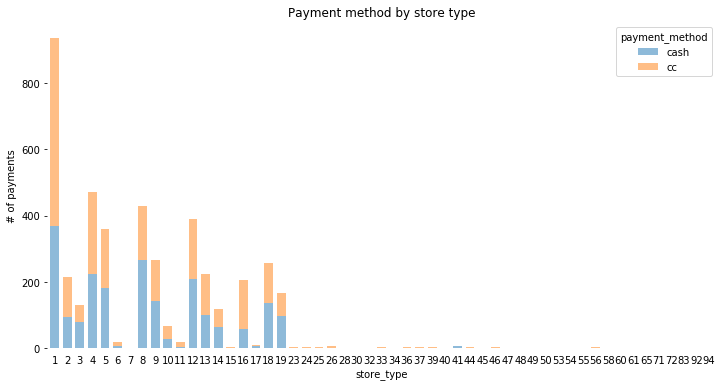

In [11]:
barplot(df['obsf_store_type'], df['payment_method'], 'Payment method by store type', 'store_type', '# of payments', (12,6))

- When the distance between user and store increase, the number of transactions decrease. The delivery will take much more longer. 
- There is a slight difference between the payment method used to pay depending on the user-store distance. When the distance increses, people tend to pay with cash.

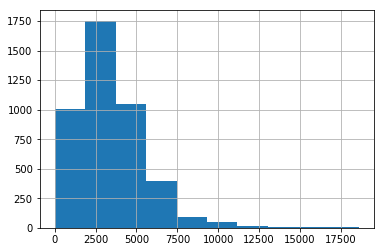

In [12]:
# store_to_user_distance distribution
df['store_to_user_distance'].hist()
plt.show()

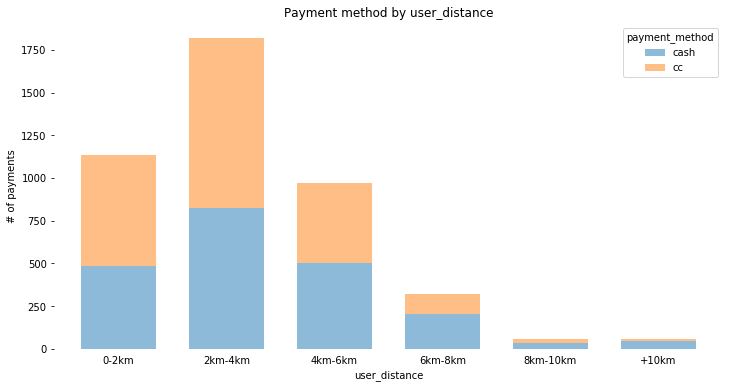

In [13]:
df_expl['store_to_user_distance_cat'] = pd.cut(df['store_to_user_distance'], bins=[0, 2000, 4000, 6000, 8000, 10000, np.inf], 
                               labels=['0-2km', '2km-4km', '4km-6km', '6km-8km', '8km-10km', '+10km'])
barplot(df_expl['store_to_user_distance_cat'], df['payment_method'], 'Payment method by user_distance', 'user_distance', '# of payments', (12,6))

## Analytics

- Top 20 searched keywords

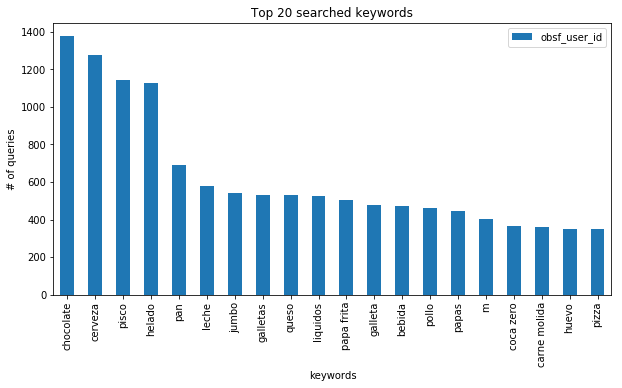

In [14]:
plotting(analytics,'keyword','obsf_user_id', 20, 'Top 20 searched keywords', 'keywords')

- Searches by event type

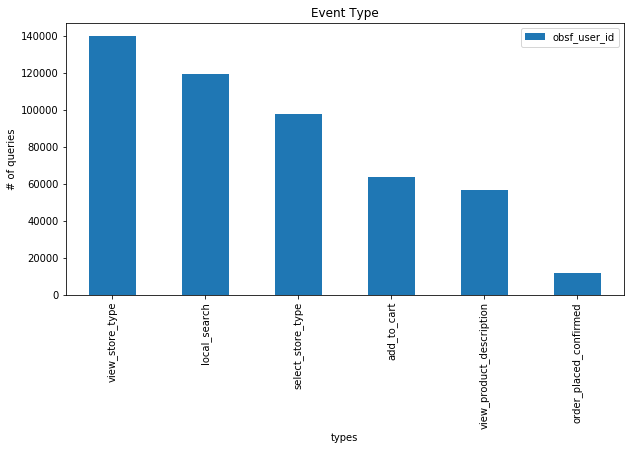

In [15]:
plotting(analytics,'event_type','obsf_user_id', 10, 'Event Type', 'types')

- Android platform generates more searches than iOS, just by 9k.
- Conversition rate is higher in iOS platform
- People tend to search more in iOS, but they add much less products to the cart than Android users

In [16]:
# numbers of events by platform
analytics.platform.value_counts()

Android    249057
iOS        240201
Name: platform, dtype: int64

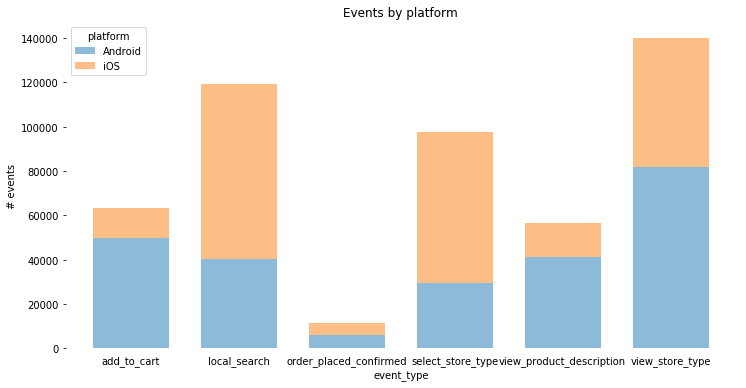

In [17]:
barplot(analytics['event_type'], analytics['platform'], 'Events by platform', 'event_type', '# events', (12,6))

# Predicting customer's payment method

In [18]:
# create new features
df['hour'] = df['created_at'].dt.hour
df['day'] = df['created_at'].dt.day
df.head()

,order_id,product_id,payment_method,total_value,created_at,store_to_user_distance,obsf_user_id,obsf_store_type,hour,day
0,35394843,2090144731,cash,1940.0,2019-04-15 14:00:00,488.0,8540,5,14,15
1,35419116,2090144731,cc,8900.0,2019-04-16 21:00:00,4761.0,3990,14,21,16
2,35404241,2090144731,cash,150.0,2019-04-15 21:00:00,3141.0,19052,5,21,15
3,35405366,2090144731,cash,400.0,2019-04-15 22:00:00,3070.0,16978,14,22,15
4,35406544,2090144731,cash,9580.0,2019-04-16 00:00:00,1210.0,9521,5,0,16


In [19]:
# create X and y
X = df[['total_value','store_to_user_distance','obsf_store_type', 'day', 'hour']].values
y = df['payment_method'].map({'cash':0,'cc':1}).values

# scaling numerical columns
scaler = StandardScaler()
X = scaler.fit_transform(X.astype(np.float))

# split dataframe into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# train a classifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)
# predict payment method
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

0.7784568372803667


In [21]:
# calculate feature importance
features = ['total_value','store_to_user_distance','obsf_store_type', 'day', 'hour']
feature_importance = pd.DataFrame({'importance':clf.feature_importances_}, index=features).sort_values('importance', ascending=False)
feature_importance

,importance
total_value,0.513007
store_to_user_distance,0.244950
hour,0.110113
obsf_store_type,0.103983
day,0.027947


The most important feature when predicting customer's payment method is the **total amount** of the order. For higher amounts, people tend to pay with credit card.  